In [1]:
from mlwpy import *
from helpers import *

In [2]:
diabetes = datasets.load_diabetes()

d_tts = skms.train_test_split(diabetes.data,
                              diabetes.target, 
                              test_size=.25,
                              random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs, 
 diabetes_train_tgt,  diabetes_test_tgt) = d_tts

# Penalized Regression

##### Errors

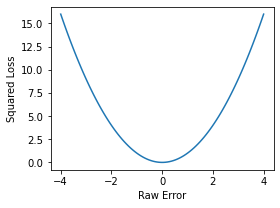

In [3]:
error = np.linspace(-4, 4, 100)
squared_loss = error**2

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(error, squared_loss)

ax.set_xlabel("Raw Error")
ax.set_ylabel("Squared Loss");

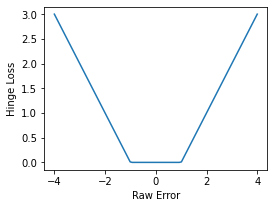

In [4]:
error = np.linspace(-4, 4, 100)
tolerance = 1.0
hinge_loss = np.maximum(np.abs(error) - tolerance, 
                        np.zeros_like(error))

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(error, hinge_loss)

ax.set_xlabel("Raw Error")
ax.set_ylabel("Hinge Loss");

(0.0, 8.0)

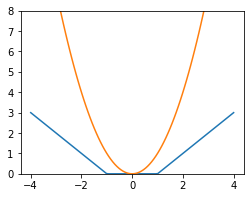

In [5]:
plt.plot(error, hinge_loss)
plt.plot(error, squared_loss)
plt.ylim(0, 8)

##### ... and Costs

In [6]:
# cost = cost from loss + cost from complexity
#
# loss comes from errors
# complexity comes from *weights*
# (we want to penalize big weights)

In [7]:
gof_lm = (linear_model.LinearRegression()
                      .fit(diabetes_train_ftrs, 
                           diabetes_train_tgt))
weights = np.append(gof_lm.coef_, gof_lm.intercept_)
weights

array([  47.7466, -241.9918,  531.9686,  381.5653, -918.4902,  508.2515,
        116.9404,  269.4851,  695.8062,   26.3234,  151.6652])

In [8]:
errors = (gof_lm.predict(diabetes_test_ftrs) - diabetes_test_tgt)
loss_sse   = np.sum(errors**2)
loss_hinge = np.sum(np.maximum(np.abs(error) - 1.0, 
                               np.zeros_like(error)))

In [9]:
loss_sse

316160.77918055665

In [10]:
loss_hinge

114.3838383838384

In [11]:
complexity_ssw = np.sum(weights**2)

In [12]:
complexity_saw = np.sum(np.abs(weights))

In [13]:
C = 5.0
costs = [('gof'    , loss_sse   + 0.0),
         ('L1(saw)', loss_sse   + C * complexity_saw),
         ('L2(ssw)', loss_sse   + C * complexity_ssw),
         ('SVR'    , loss_hinge + C * complexity_ssw)]
pd.DataFrame.from_records(costs).set_index(0)

,1
0,
gof,"316,160.7792"
L1(saw),"335,611.9504"
L2(ssw),"11,243,685.9558"
SVR,"10,927,639.5604"


##### Diving into SVR

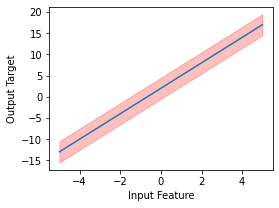

In [14]:
threshold = 2.5

xs = np.linspace(-5,5,100)
ys_true = 3 * xs + 2

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(xs, ys_true)
ax.fill_between(xs, ys_true-threshold, ys_true+threshold, 
                 color=(1.0,0,0,.25))

ax.set_xlabel('Input Feature')
ax.set_ylabel('Output Target');

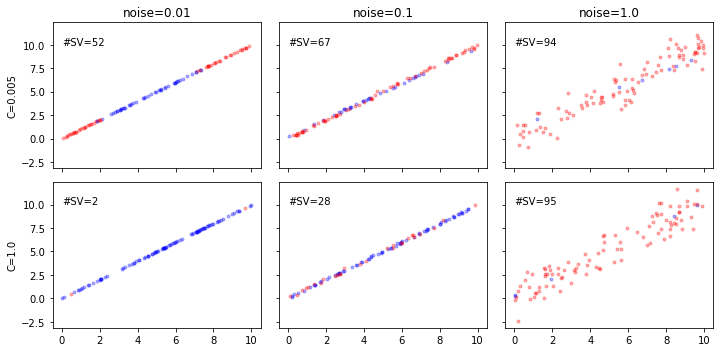

In [15]:
show_svr_penalty_noise()

##### Go!

In [16]:
models = [linear_model.Lasso(),            # L1 regularized; C=1.0
          linear_model.Ridge(),            # L2 regularized; C=1.0
          svm.SVR(gamma='auto'),           # default epsilon=0.1 
          svm.NuSVR(gamma='auto')]         # default nu=0.5

results = []
for model in models:
    model.fit(diabetes_train_ftrs, diabetes_train_tgt)
    
    train_preds = model.predict(diabetes_train_ftrs)
    test_preds  = model.predict(diabetes_test_ftrs)
    
    mse = metrics.mean_squared_error
    train_mse = mse(diabetes_train_tgt, train_preds)
    test_mse = mse(diabetes_test_tgt, test_preds)
    
    results.append((get_model_name(model), train_mse, test_mse))

(pd.DataFrame
   .from_records(results, columns=['model', 'train', 'test'])
   .set_index('model'))

,train,test
model,,
Lasso,"3,947.8999","3,433.1525"
Ridge,"3,461.7395","3,105.4688"
SVR,"6,167.7591","5,516.3462"
NuSVR,"6,039.6906","5,527.5201"


# Piecewise Constant Regression

In [17]:
ftrs = np.arange(10.0).reshape((10,1))
tgts = np.array([ 5, 4.75, 5.25, 
                 .8,  1.0,  1.2, 
                  7,    7,    7, 7.5])

constants: [5.    1.    7.125]
rmse: 0.19811612756158947


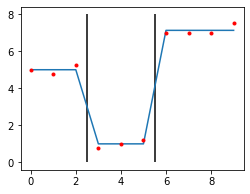

In [18]:
cut_points = [2.5, 5.5] # cut points in values of x
model = PiecewiseConstantRegression(cut_points=cut_points)
model.fit(ftrs, tgts)
preds = model.predict(ftrs)

print('constants:', model.coeffs_)
print('rmse:', np.sqrt(metrics.mean_squared_error(tgts, preds)))

plt.plot(ftrs, preds)
plt.plot(ftrs, tgts, 'r.')

plt.vlines(cut_points, 0, 8, 'k');

constants: [5.    1.    7.125]
rmse: 0.19811612756158947


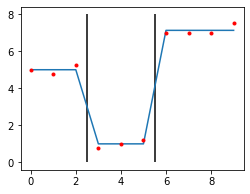

In [19]:
go_cutpoints(ftrs, tgts, [2.5, 5.5])

constants: [3.36 5.94]
rmse: 2.2042912693199144


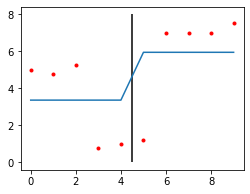

In [20]:
go_cutpoints(ftrs, tgts, [4.5])

constants: [4.875 3.025 1.1   7.    7.25 ]
rmse: 1.0038675211401153


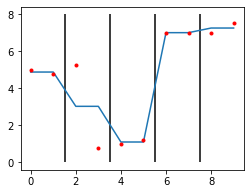

In [21]:
go_cutpoints(ftrs, tgts, [1.5, 3.5, 5.5, 7.5])

constants: [5.   4.75 5.25 0.8  1.   1.2  7.   7.   7.   7.5 ]
rmse: 0.0


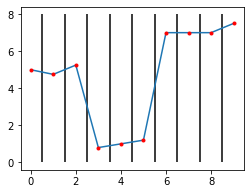

In [22]:
go_cutpoints(ftrs, tgts, np.arange(9.0)+.5)

# Regression Trees

In [23]:
depths = [1,2,5,10]
fit_models = {}
for md in depths:
    model = tree.DecisionTreeRegressor(max_depth=md)
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    mse = metrics.mean_squared_error(diabetes_test_tgt, preds)
    fmt = "{} {:2d} {:4.0f}"
    print(fmt.format(get_model_name(model),
                     model.get_params()['max_depth'],
                     mse))
    fit_models[md] = model

DecisionTreeRegressor  1 4341
DecisionTreeRegressor  2 3649
DecisionTreeRegressor  5 4310
DecisionTreeRegressor 10 5084


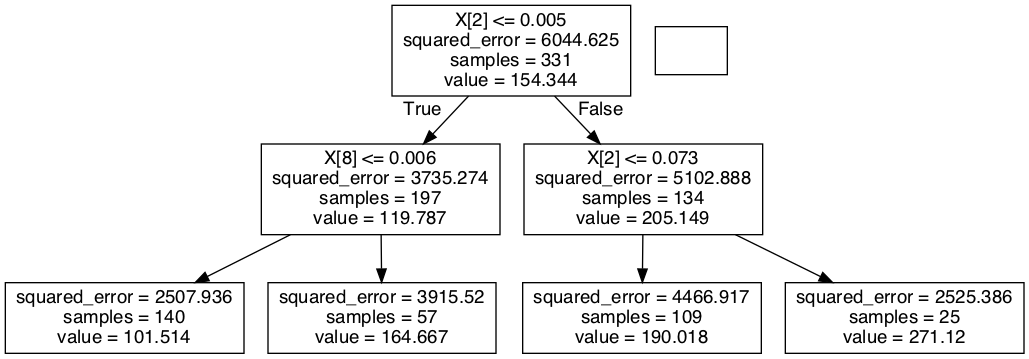

In [24]:
import pydotplus

dot_data = tree.export_graphviz(fit_models[2], out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("outputs/dtr.png")

Image("outputs/dtr.png", width=800, height=800)

In [25]:
model = tree.DecisionTreeRegressor(max_depth=None)
model.fit(diabetes_train_ftrs, diabetes_train_tgt)
model.tree_.max_depth

17

In [26]:
preds = model.predict(diabetes_train_ftrs)
metrics.mean_squared_error(diabetes_train_tgt, preds)

0.0

In [27]:
preds = model.predict(diabetes_test_ftrs)
metrics.mean_squared_error(diabetes_test_tgt, preds)

5979.261261261261

# Comparing Regressors

In [28]:
student_df = pd.read_csv('data/portugese_student_numeric.csv')
student_ftrs = student_df[student_df.columns[:-1]]
student_tgt  = student_df['G3']

student_tts = skms.train_test_split(student_ftrs, student_tgt)

(student_train_ftrs, student_test_ftrs,
 student_train_tgt,  student_test_tgt) = student_tts

In [29]:
student_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,18,4,4,2,2,0,4,3,4,1,1,3,6,6
1,17,1,1,1,2,0,5,3,3,1,1,3,4,6
2,15,1,1,1,2,3,4,3,2,2,3,3,10,10
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15
4,16,3,3,1,2,0,4,3,2,1,2,5,4,10


In [30]:
old_school = [linear_model.LinearRegression(),
              neighbors.KNeighborsRegressor(n_neighbors=3),
              neighbors.KNeighborsRegressor(n_neighbors=10)]

# L1, L2 penalized (abs, sqr) C=1.0 for both
penalized_lr = [linear_model.Lasso(), 
                linear_model.Ridge()]

# defaults are epsilon=.1 and nu=.5, respectively
svrs = [svm.SVR(), svm.NuSVR()] 

dtrees = [tree.DecisionTreeRegressor(max_depth=md) 
               for md in [1, 3, 5, 10]]

reg_parade = old_school + penalized_lr + svrs + dtrees

In [31]:
scaler = skpre.StandardScaler()

errors = {}
for model in reg_parade:
    pipe = pipeline.make_pipeline(scaler, model)
    preds = skms.cross_val_predict(pipe, 
                                   student_ftrs, student_tgt, 
                                   cv=10)
    key = (get_model_name(model) + 
           str(model.get_params().get('max_depth', "")) + 
           str(model.get_params().get('n_neighbors', "")))
    errors[key] = rms_error(student_tgt, preds)
    
df = pd.DataFrame.from_dict(errors, orient='index').sort_values(0)
df.columns=['RMSE']
display(df)

,RMSE
DecisionTreeRegressor1,4.3192
Ridge,4.3646
LinearRegression,4.3653
NuSVR,4.3896
SVR,4.4062
DecisionTreeRegressor3,4.4298
Lasso,4.4375
KNeighborsRegressor10,4.4869
DecisionTreeRegressor5,4.7109
KNeighborsRegressor3,4.8915


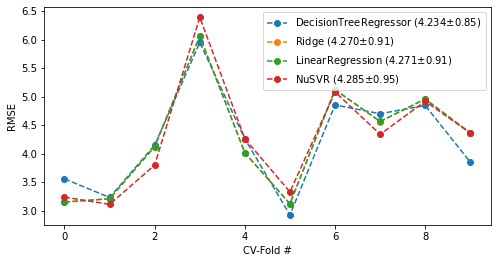

In [32]:
better_models = [tree.DecisionTreeRegressor(max_depth=1),
                 linear_model.Ridge(),
                 linear_model.LinearRegression(),
                 svm.NuSVR()]

fig, ax = plt.subplots(1, 1, figsize=(8,4))
for model in better_models:
    pipe = pipeline.make_pipeline(scaler, model)    
    cv_results = skms.cross_val_score(pipe, 
                                      student_ftrs, student_tgt, 
                                      scoring = rms_scorer, 
                                      cv=10)

    my_lbl = "{:s} ({:5.3f}$\pm${:.2f})".format(get_model_name(model), 
                                                cv_results.mean(), 
                                                cv_results.std())
    ax.plot(cv_results, 'o--', label=my_lbl)
    ax.set_xlabel('CV-Fold #')
    ax.set_ylabel("RMSE")
    ax.legend()